In [1]:
import pandas as pd

from mlforecast import MLForecast
from statsforecast import StatsForecast
from sklearn.linear_model import LinearRegression
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
from window_ops.ewm import ewm_mean

from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast.core import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM, AutoTFT, LSTM
from neuralforecast.losses.pytorch import MQLoss
import matplotlib.pyplot as plt

from statsforecast.models import (
    # SeasonalNaive: A model that uses the previous season's data as the forecast
    SeasonalNaive
)

/home/jan_rathfelder/Development/env_basic/lib/python3.9/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def create_date_format(
        df: pd.DataFrame, original_date_column: str
    ) -> pd.DataFrame:
        """
        Creates a pandas datetime object from a date string.
        Very specifiy to the output of the mdb notebook yrmo column.
        """
        df["yyyymm"] = df[original_date_column].apply(
            lambda x: str(x)[:4] + "-" + str(x)[4:] + "-01"
        )
        df["yyyymm"] = pd.to_datetime(df.yyyymm)
        return df

In [ ]:
static_df = df.pivot_table(values='total_hcp_cnt', index=['country_cd'], columns='cstmr_1_id', aggfunc='sum', fill_value=0).sum(axis=1).reset_index(name='total_hcp_cnt')
static_df.rename(columns={'country_cd': 'unique_id', 'yyyymm': 'ds'}, inplace=True)

In [139]:
df = pd.read_csv('s3://dsaa-cph-ai-s3-dev/jan_rathfelder/impact_data/fra_eylea_20230215.csv')
df = create_date_format(df, 'yrmo')

df = df[df.cstmr_1_id!='-']

df_nixtla = df[['cstmr_1_id', 'yyyymm', 'sales_unit', 'f2f_calls', 'remote_calls','ae_sent','evnt_invited']]
df_nixtla.rename(columns={'cstmr_1_id': 'unique_id', 'yyyymm': 'ds', 'sales_unit': 'y'}, inplace=True)

static_df = df.pivot_table(values='total_hcp_cnt', index=['cstmr_1_id'], aggfunc='mean', fill_value=0).sum(axis=1).reset_index(name='total_hcp_cnt')
static_df.rename(columns={'cstmr_1_id': 'unique_id', 'yyyymm': 'ds'}, inplace=True)

In [138]:
df_nixtla.head(2)

,unique_id,ds,y,f2f_calls,remote_calls,ae_sent,evnt_invited,total_hcp_cnt
0,01BEL,2019-01-01,0.84091,0.0,0.0,0.0,0.0,0.0
1,01BEL,2019-02-01,0.64201,0.0,0.0,0.0,0.0,0.0


In [133]:
# lstm search spacce:

horizon=12

config_lstm = dict(
    input_size= tune.choice([horizon*1, horizon*2]),              # Length of input window
    encoder_hidden_size= tune.randint(12, 64),            # Hidden size of LSTM cells
    encoder_n_layers= tune.randint(2,5),                   # Number of layers in LSTM
    learning_rate= tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
    scaler_type= tune.choice(['robust', 'standard']),                   # Scaler type
    max_steps= tune.randint(500, 1500),                    # Max number of training iterations
    batch_size= tune.choice([16, 32, 64, 128]),                        # Number of series in batch
    # random_seed= tune.randint(1, 20),                       # Random seed
    hist_exog_list=['f2f_calls', 'remote_calls','ae_sent','evnt_invited'],
    futr_exog_list =['f2f_calls', 'remote_calls','ae_sent','evnt_invited'],
    stat_exog_list = ['total_hcp_cnt']
)

model = [AutoLSTM(h=horizon,
                  config=config_lstm, 
                  #futr_exog_list = ['gen_forecast', 'week_day'], # <- Future exogenous variables
                  #hist_exog_list = ['total_calls'], # <- Historical exogenous variables
                  #stat_exog_list = ['market_0', 'market_1'], # <- Static exogenous variables
                  loss = MQLoss(),
                  num_samples=40, # number of configurations explored --> ideally above 25,
                  search_alg=HyperOptSearch())
         ]

In [79]:
# Use your own config or AutoNHITS.default_config:
horizon=6

nhits_config = dict(
    input_size = tune.choice([horizon*1, horizon*2]), # if horizon is a variable and you want to just multiply it.
    activation=tune.choice(['ReLU', 'Softplus',]), #'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid']),
    stack_types=tune.choice([['identity', 'identity'], ['identity']]),
    n_blocks=tune.choice([[1, 1], [2, 2], [1]]),
    #mlp_units=tune.choice([[[32, 32], [64, 64]], [[32], [64]]]),
    #n_freq_downsample=tune.choice([[2, 2], [1, 1], [2]]),
    interpolation_mode=tune.choice(['linear', 'nearest']),
    #n_pool_kernel_size=tune.choice([[2, 2, 2], [16, 8, 1]]), 
    pooling_mode=tune.choice(['MaxPool1d', 'AvgPool1d']),
    dropout_prob_theta=tune.uniform(0.0, 0.5),
    max_steps=tune.randint(15, 400),
    learning_rate=tune.loguniform(1e-4, 1e-2),
    num_lr_decays=tune.quniform(-1, 8, 1),
    #early_stop_patience_steps=tune.choice([-1, tune.randint(10, 51)]),
    val_check_steps=tune.quniform(50, 200, 50),
    batch_size=tune.randint(16, 256),
    valid_batch_size=tune.randint(16, 256), 
    windows_batch_size=tune.randint(16, 256),
    scaler_type=tune.choice(['identity', 'robust', 'standard', 'minmax']),
    step_size=tune.randint(1, 3),
    start_padding_enabled=tune.choice([True, False]),
    drop_last_loader=tune.choice([True, False]),
    hist_exog_list=['f2f_calls', 'remote_calls','ae_sent','evnt_invited','total_hcp_cnt'],
    futr_exog_list =['f2f_calls', 'remote_calls','ae_sent','evnt_invited','total_hcp_cnt'],
    stat_exog_list = ['total_hcp_cnt']
)

horizon=6

model = [AutoNHITS(h=horizon,
                    config=nhits_config, 
                    loss = MQLoss(),
                    num_samples=25, # number of configurations explored --> ideally above 25,
                    search_alg=HyperOptSearch()) # number of configurations explored --> ideally above 20!!
         ]

In [44]:
# config for TFT --> Transformer
horizon=6

tft_config = dict(
    input_size = tune.choice([horizon*1, horizon*2]), # if horizon is a variable and you want to just multiply it.
    hidden_size = tune.randint(12, 64),
    dropout = tune.uniform(0.0, 0.5),
    n_head = tune.choice([2, 4, 8]),
    attn_dropout = tune.uniform(0.0, 0.5),
    #shared_weights = tune.choice([True, False]),
    #activation = tune.choice(['ReLU', 'Softplus']), # 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid']),
    max_steps = tune.randint(20, 500),
    learning_rate = tune.loguniform(1e-4, 1e-2),
    num_lr_decays = tune.loguniform(0.01, .5),
    early_stop_patience_steps = tune.choice([-1, 10, 50]),
    val_check_steps = tune.choice([5, 10, 35]),
    batch_size = tune.randint(12, 128),
    #windows_batch_size = tune.choice([None, 50, 100]),
    scaler_type = tune.choice(['robust', 'standard', 'minmax']),
)

model = [AutoTFT(h=horizon,
                    config=tft_config, 
                    loss = MQLoss(),
                    num_samples=15, # number of configurations explored --> ideally above 25,
                    search_alg=HyperOptSearch()) # number of configurations explored --> ideally above 20!!
         ]

In [140]:
df_nixtla2 = df_nixtla[df_nixtla.ds<'2021-12-01'].copy()

nf = NeuralForecast(
    models=model,
    freq='MS')

val_size  = 12 # 1 x 6 months
test_size = 12 # 1 x 6 months

Y_hat_df = nf.cross_validation(df=df_nixtla2, 
                               static_df=static_df,
                               val_size=val_size,
                               test_size=test_size, 
                               n_windows=None)

(_train_tune pid=11596) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 97.79it/s, v_num=0, train_loss_step=0.297, train_loss_epoch=0.374]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:01, 28.20it/s] 
(_train_tune pid=11596) 
Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:01, 29.78it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 47.29it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  85%|████████▌ | 41/48 [00:01<00:00, 33.09it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  88%|████████▊ | 42/48 [00:01<00:00, 33.71it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  90%|████████▉ | 43/48 [00:01<00:00, 34.33it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  92%|█████████▏| 44/48 [00:01<00:00, 34.96it/s]
(_train_tune pid=11596) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 110.19it/s, v_num=0, train_loss_step=0.337, train_loss_epoch=0.361, valid_loss=5.350] 
Validation: |          

2023-10-31 17:08:54,108	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=11596) 
Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 144.94it/s]
(_train_tune pid=11596) 
Epoch 27:  27%|██▋       | 13/48 [00:00<00:01, 28.45it/s, v_num=0, train_loss_step=0.292, train_loss_epoch=0.315, valid_loss=6.180]


(_train_tune pid=11596) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 64.62it/s, v_num=0, train_loss_step=0.176, train_loss_epoch=0.178] 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:   0%|          | 0/12 [00:00<?, ?it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  83%|████████▎ | 10/12 [00:00<00:00, 88.86it/s]
(_train_tune pid=11596) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 64.33it/s, v_num=0, train_loss_step=0.167, train_loss_epoch=0.175, valid_loss=5.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  50%|█████     | 6/12 [00:00<00:00, 82.07it/s]
(_train_tune pid=11596) 
Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 66.45it/s, v_num=0, train_loss_step=0.169, train_loss_epoch=0.173, valid_loss=5.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 2/12 [00:00<00:00, 85.10it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  83%|████████▎ | 10/12 [00:00<00:00, 80.71it/s]
(_train

2023-10-31 17:09:11,239	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 83:  33%|███▎      | 4/12 [00:00<00:00, 63.70it/s, v_num=0, train_loss_step=0.139, train_loss_epoch=0.140, valid_loss=8.730]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  58%|█████▊    | 7/12 [00:00<00:00, 81.01it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  67%|██████▋   | 8/12 [00:00<00:00, 80.39it/s]
(_train_tune pid=11596) 
Epoch 83:  67%|██████▋   | 8/12 [00:00<00:00, 28.10it/s, v_num=0, train_loss_step=0.137, train_loss_epoch=0.141, valid_loss=9.130]


(_train_tune pid=11596) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 99.94it/s, v_num=0, train_loss_step=0.344, train_loss_epoch=0.361] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  54%|█████▍    | 13/24 [00:00<00:00, 141.14it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  58%|█████▊    | 14/24 [00:00<00:00, 141.07it/s]
(_train_tune pid=11596) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 100.98it/s, v_num=0, train_loss_step=0.267, train_loss_epoch=0.353, valid_loss=5.440] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 2/24 [00:00<00:00, 150.38it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  12%|█▎        | 3/24 [00:00<00:00, 147.10it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  75%|███████▌  | 18/24 [00:00<00:00, 143.16it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  79%|███████▉  | 19/24 [00:00<00:00, 143.03it/s]
(_train_tune pid=11596) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 100.61it/s, v_num=0, tra

2023-10-31 17:09:26,034	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 52:  29%|██▉       | 7/24 [00:00<00:00, 97.51it/s, v_num=0, train_loss_step=0.368, train_loss_epoch=0.285, valid_loss=7.280]  


(_train_tune pid=11596) Seed set to 1


Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 55.04it/s, v_num=0, train_loss_step=0.328, train_loss_epoch=0.347]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 91.21it/s]
(_train_tune pid=11596) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 53.34it/s, v_num=0, train_loss_step=0.318, train_loss_epoch=0.322, valid_loss=5.610]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 76.67it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 74.18it/s]
(_train_tune pid=11596) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 53.19it/s, v_num=0, train_loss_step=0.309, train_loss_epoch=0.305, valid_loss=6.650]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 66:  67%|██████▋   | 4/6 [00:00<00:00, 53.62it/s, v_num=0, train_loss_step=0.256, train_loss_epoch=0.291, valid_loss=6.970]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  

2023-10-31 17:09:42,627	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(_train_tune pid=11596) Seed set to 1


Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 47.77it/s, v_num=0, train_loss_step=0.319, train_loss_epoch=0.339]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 56.22it/s]
(_train_tune pid=11596) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 46.99it/s, v_num=0, train_loss_step=0.307, train_loss_epoch=0.312, valid_loss=5.950]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]
(_train_tune pid=11596) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 48.89it/s, v_num=0, train_loss_step=0.302, train_loss_epoch=0.294, valid_loss=6.680]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]
(_train_tune pid=11596) 
Epoch 66:  67%|██████▋   | 4/6 [00:00<00:00, 47.88it/s, v_num=0, train_loss_step=0.245, train_loss_epoch=0.277, valid_loss=7.300]
Validation: |          | 0/? [00:00<?,

2023-10-31 17:10:12,824	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 227:  83%|████████▎ | 5/6 [00:00<00:00, 46.96it/s, v_num=0, train_loss_step=0.222, train_loss_epoch=0.201, valid_loss=10.10]


(_train_tune pid=11596) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 107.49it/s, v_num=0, train_loss_step=0.305, train_loss_epoch=0.415]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 160.99it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 160.25it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 160.13it/s]
(_train_tune pid=11596) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 107.82it/s, v_num=0, train_loss_step=0.344, train_loss_epoch=0.367, valid_loss=5.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 160.10it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 159.65it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 159.73it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 159.71it

2023-10-31 17:10:31,746	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 31:  19%|█▉        | 9/48 [00:00<00:00, 94.00it/s, v_num=0, train_loss_step=0.268, train_loss_epoch=0.320, valid_loss=5.570]


(_train_tune pid=11596) Seed set to 1


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 51.85it/s]
                                                                           
Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00,  8.96it/s, v_num=0, train_loss_step=0.147, train_loss_epoch=0.154]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 51.22it/s]
(_train_tune pid=11596) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 46.72it/s, v_num=0, train_loss_step=0.137, train_loss_epoch=0.138, valid_loss=6.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 45.15it/s, v_num=0, train_loss_step=0.128, train_loss_epoch=0.131, valid_loss=8.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 31.86it/s]
(_train_tune pid=11596) 
Epoch 66:  67%|██████▋   | 4/6 [00:00<00:00, 44.94it/s, v_num=0, train_loss_step=0.122, train_loss_epoch=0.121, valid_loss=8.620]
Validation: |   

2023-10-31 17:10:59,508	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 166:  67%|██████▋   | 4/6 [00:00<00:00, 52.01it/s, v_num=0, train_loss_step=0.0754, train_loss_epoch=0.0762, valid_loss=9.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/24 [00:00<?, ?it/s]                             


(_train_tune pid=11596) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 98.16it/s, v_num=0, train_loss_step=0.341, train_loss_epoch=0.359]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  58%|█████▊    | 14/24 [00:00<00:00, 147.40it/s]
(_train_tune pid=11596) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 81.28it/s, v_num=0, train_loss_step=0.266, train_loss_epoch=0.348, valid_loss=5.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  21%|██        | 5/24 [00:00<00:00, 128.72it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  25%|██▌       | 6/24 [00:00<00:00, 128.25it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  79%|███████▉  | 19/24 [00:00<00:00, 124.44it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  83%|████████▎ | 20/24 [00:00<00:00, 124.14it/s]
(_train_tune pid=11596) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 98.32it/s, v_num=0, train_loss_step=0.338, train_loss_epoch=0.339, valid_loss=5.460]
Validation: |          | 0/? [00:00<?, ?i

2023-10-31 17:11:14,256	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=11596) 
Validation DataLoader 0:  67%|██████▋   | 16/24 [00:00<00:00, 145.82it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  71%|███████   | 17/24 [00:00<00:00, 145.59it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  75%|███████▌  | 18/24 [00:00<00:00, 145.35it/s]
(_train_tune pid=11596) 
Epoch 50:  25%|██▌       | 6/24 [00:00<00:00, 93.77it/s, v_num=0, train_loss_step=0.252, train_loss_epoch=0.356, valid_loss=7.050]


(_train_tune pid=11596) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 103.70it/s, v_num=0, train_loss_step=0.297, train_loss_epoch=0.379] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 167.43it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 166.12it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 165.22it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 163.31it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 163.37it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 163.28it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 163.31it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 163.19it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  90%|████████▉ | 43/48 [00

2023-10-31 17:11:32,419	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=11596) 
Epoch 29:  48%|████▊     | 23/48 [00:00<00:00, 43.46it/s, v_num=0, train_loss_step=0.380, train_loss_epoch=0.303, valid_loss=6.230]


(_train_tune pid=11596) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 100.63it/s, v_num=0, train_loss_step=0.171, train_loss_epoch=0.173] 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:   4%|▍         | 1/24 [00:00<00:00, 150.36it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  67%|██████▋   | 16/24 [00:00<00:00, 137.66it/s]
(_train_tune pid=11596) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 100.38it/s, v_num=0, train_loss_step=0.134, train_loss_epoch=0.149, valid_loss=5.720]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 2/24 [00:00<00:00, 144.03it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  12%|█▎        | 3/24 [00:00<00:00, 128.91it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  75%|███████▌  | 18/24 [00:00<00:00, 132.50it/s]
(_train_tune pid=11596) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 98.18it/s,

2023-10-31 17:11:44,104	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 0:   2%|▏         | 1/48 [00:00<00:00, 85.15it/s, v_num=0, train_loss_step=0.546]


(_train_tune pid=11596) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 108.96it/s, v_num=0, train_loss_step=0.288, train_loss_epoch=0.365]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 163.81it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 163.53it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 163.39it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  29%|██▉       | 14/48 [00:00<00:00, 163.26it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 163.06it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 163.02it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 163.03it/s]
(_train_tune pid=11596) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 108.57it/s, v_num=0, train_loss_step=0.330, train_loss_epoch=0.357, valid_loss=5.320]
Validation: |    

2023-10-31 17:11:56,074	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=11596) Seed set to 1


Epoch 20:  38%|███▊      | 18/48 [00:00<00:00, 109.96it/s, v_num=0, train_loss_step=0.377, train_loss_epoch=0.319, valid_loss=6.310]
Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 74.54it/s, v_num=0, train_loss_step=0.170, train_loss_epoch=0.173]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  50%|█████     | 6/12 [00:00<00:00, 112.50it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  58%|█████▊    | 7/12 [00:00<00:00, 111.64it/s]
(_train_tune pid=11596) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 75.18it/s, v_num=0, train_loss_step=0.143, train_loss_epoch=0.153, valid_loss=5.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 3/12 [00:00<00:00, 114.50it/s]
(_train_tune pid=11596) 
Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 74.63it/s, v_num=0, train_loss_step=0.142, train_loss_epoch=0.145, valid_loss=6.840]
Validation: |          | 0/? [00:00<?, ?it/s]
Validatio

2023-10-31 17:12:14,571	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 103:   8%|▊         | 1/12 [00:00<00:00, 72.88it/s, v_num=0, train_loss_step=0.121, train_loss_epoch=0.126, valid_loss=9.570] 


(_train_tune pid=11596) Seed set to 1


Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 52.66it/s, v_num=0, train_loss_step=0.417, train_loss_epoch=0.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 71.04it/s]
                                                                      
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 51.65it/s, v_num=0, train_loss_step=0.376, train_loss_epoch=0.370, valid_loss=6.760]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 54.55it/s]
(_train_tune pid=11596) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 52.79it/s, v_num=0, train_loss_step=0.365, train_loss_epoch=0.364, valid_loss=5.410]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]
(_train_tune pid=11596) 
Epoch 66:  67%|██████▋   | 4/6 [00:00<00:00, 53.08it/s, v_num=0, train_loss_step=0.336, train_loss_epoch=0.361, valid_loss=5.360]
Validatio

2023-10-31 17:12:49,721	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 236:  50%|█████     | 3/6 [00:00<00:00, 43.11it/s, v_num=0, train_loss_step=0.504, train_loss_epoch=0.375, valid_loss=5.640]


(_train_tune pid=11596) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 100.89it/s, v_num=0, train_loss_step=0.183, train_loss_epoch=0.252]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 161.78it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 161.30it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 80.89it/s] 
(_train_tune pid=11596) 
Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 82.06it/s]
(_train_tune pid=11596) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 102.17it/s, v_num=0, train_loss_step=0.182, train_loss_epoch=0.184, valid_loss=5.580]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 129.25it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 154.66it/s]
(_train_

2023-10-31 17:13:01,615	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 18:  42%|████▏     | 20/48 [00:00<00:00, 100.06it/s, v_num=0, train_loss_step=0.182, train_loss_epoch=0.173, valid_loss=5.340]
Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(_train_tune pid=11596) Seed set to 1


Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 56.90it/s, v_num=0, train_loss_step=0.199, train_loss_epoch=0.212]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 101.94it/s]
(_train_tune pid=11596) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 57.46it/s, v_num=0, train_loss_step=0.184, train_loss_epoch=0.184, valid_loss=5.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 73.42it/s]
(_train_tune pid=11596) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 57.40it/s, v_num=0, train_loss_step=0.176, train_loss_epoch=0.179, valid_loss=5.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 75.00it/s]
(_train_tune pid=11596) 
Epoch 66:  67%|██████▋   | 4/6 [00:00<00:00, 51.01it/s, v_num=0, train_loss_step=0.178, train_loss_epoch=0.176, v

2023-10-31 17:13:13,165	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99:  83%|████████▎ | 5/6 [00:00<00:00, 56.24it/s, v_num=0, train_loss_step=0.174, train_loss_epoch=0.173, valid_loss=5.490]


(_train_tune pid=11596) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 70.23it/s, v_num=0, train_loss_step=0.169, train_loss_epoch=0.172]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  75%|███████▌  | 9/12 [00:00<00:00, 105.75it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  83%|████████▎ | 10/12 [00:00<00:00, 105.25it/s]
(_train_tune pid=11596) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 71.34it/s, v_num=0, train_loss_step=0.141, train_loss_epoch=0.149, valid_loss=5.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 2/12 [00:00<00:00, 112.97it/s]
(_train_tune pid=11596) 
Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 71.28it/s, v_num=0, train_loss_step=0.140, train_loss_epoch=0.142, valid_loss=7.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  33%|███▎      | 4/12 [00:00<00:00, 110.23it/s]
(_train_tune pid=11596) 
Epoch 33:  33%|███▎      | 4/12 [00:00<00:00, 69.74it/s, v_num=0, train_loss_step=0.135, train

2023-10-31 17:13:33,966	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 111:  17%|█▋        | 2/12 [00:00<00:00, 66.21it/s, v_num=0, train_loss_step=0.115, train_loss_epoch=0.109, valid_loss=9.290] 


(_train_tune pid=11596) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 106.79it/s, v_num=0, train_loss_step=0.354, train_loss_epoch=0.369] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  12%|█▎        | 3/24 [00:00<00:00, 156.87it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  17%|█▋        | 4/24 [00:00<00:00, 153.96it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  83%|████████▎ | 20/24 [00:00<00:00, 150.37it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  88%|████████▊ | 21/24 [00:00<00:00, 150.10it/s]
(_train_tune pid=11596) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 106.88it/s, v_num=0, train_loss_step=0.266, train_loss_epoch=0.359, valid_loss=5.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 6/24 [00:00<00:00, 150.38it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  92%|█████████▏| 22/24 [00:00<00:00, 149.65it/s]
(_train_tune pid=11596) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 107.00it/s, v_num=0, trai

2023-10-31 17:13:43,822	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(_train_tune pid=11596) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 82.73it/s, v_num=0, train_loss_step=0.307, train_loss_epoch=0.353]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  75%|███████▌  | 9/12 [00:00<00:00, 116.53it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  83%|████████▎ | 10/12 [00:00<00:00, 115.72it/s]
(_train_tune pid=11596) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 83.71it/s, v_num=0, train_loss_step=0.305, train_loss_epoch=0.332, valid_loss=5.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  75%|███████▌  | 9/12 [00:00<00:00, 117.33it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  83%|████████▎ | 10/12 [00:00<00:00, 116.53it/s]
(_train_tune pid=11596) 
Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 83.68it/s, v_num=0, train_loss_step=0.279, train_loss_epoch=0.321, valid_loss=5.900]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  83%|████████▎ | 10/12 [00:00<00:00, 116.63it/s]
(_train_tune pid=11

2023-10-31 17:13:57,346	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=11596) 
Epoch 84:  42%|████▏     | 5/12 [00:00<00:00, 80.99it/s, v_num=0, train_loss_step=0.240, train_loss_epoch=0.252, valid_loss=8.280] 


(_train_tune pid=11596) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 124.27it/s, v_num=0, train_loss_step=0.310, train_loss_epoch=0.450] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 180.24it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 177.78it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  46%|████▌     | 22/48 [00:00<00:00, 175.31it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 175.27it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 175.22it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 175.01it/s]
(_train_tune pid=11596) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 123.59it/s, v_num=0, train_loss_step=0.351, train_loss_epoch=0.372, valid_loss=6.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 177.10it/s

2023-10-31 17:14:10,226	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 24:  46%|████▌     | 22/48 [00:00<00:00, 124.15it/s, v_num=0, train_loss_step=0.306, train_loss_epoch=0.351, valid_loss=5.390]


(_train_tune pid=11596) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 113.47it/s, v_num=0, train_loss_step=0.311, train_loss_epoch=0.447]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 170.01it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  73%|███████▎  | 35/48 [00:00<00:00, 169.29it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 169.18it/s]
(_train_tune pid=11596) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 113.42it/s, v_num=0, train_loss_step=0.345, train_loss_epoch=0.370, valid_loss=6.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 171.25it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 171.09it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 170.44it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 170.31it/s]

2023-10-31 17:14:20,563	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=11596) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 100.44it/s, v_num=0, train_loss_step=0.265, train_loss_epoch=0.318] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 172.16it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 164.34it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 161.78it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 160.61it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 159.97it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 159.49it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  48%|████▊     | 23/48 [00:00<00:00, 158.88it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 158.81it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00

2023-10-31 17:14:30,029	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=11596) 
Epoch 14:  75%|███████▌  | 36/48 [00:00<00:00, 53.81it/s, v_num=0, train_loss_step=0.173, train_loss_epoch=0.177, valid_loss=5.380]


(_train_tune pid=11596) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 79.02it/s, v_num=0, train_loss_step=0.273, train_loss_epoch=0.326]  
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 152.86it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 159.40it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 159.59it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 159.68it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 159.83it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 160.94it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 160.94it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  96%|█████████▌| 46/48 [00:00<00:00, 160.89it/s]
(_train_tune pid=11596) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 104.

2023-10-31 17:14:41,151	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=11596) Seed set to 1


(_train_tune pid=11596) 
Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 100.15it/s, v_num=0, train_loss_step=0.255, train_loss_epoch=0.307]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 158.85it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 158.74it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 158.55it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 158.19it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 158.18it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  98%|█████████▊| 47/48 [00:00<00:00, 158.35it/s]
(_train_tune pid=11596) 
Validation DataLoader 0: 100%|██████████| 48/48 [00:00<00:00, 158.56it/s]
(_train_tune pid=11596) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 100.34it/s, v_num=0, train_loss_step=0.195, train_loss_epoch=0.212, valid_loss

2023-10-31 17:14:51,609	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=11596) 
Validation DataLoader 0:  85%|████████▌ | 41/48 [00:00<00:00, 157.38it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 157.30it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 157.26it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 157.23it/s]
(_train_tune pid=11596) 
Epoch 14:  65%|██████▍   | 31/48 [00:00<00:00, 49.79it/s, v_num=0, train_loss_step=0.179, train_loss_epoch=0.178, valid_loss=5.390] 


(_train_tune pid=11596) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 102.46it/s, v_num=0, train_loss_step=0.249, train_loss_epoch=0.309] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 176.45it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 160.88it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 160.73it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 161.12it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 161.11it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 161.14it/s]
(_train_tune pid=11596) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 105.72it/s, v_num=0, train_loss_step=0.188, train_loss_epoch=0.195, valid_loss=7.190]
Validation: |          | 0/

2023-10-31 17:14:58,262	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 11:   2%|▏         | 1/48 [00:00<00:00, 90.76it/s, v_num=0, train_loss_step=0.170, train_loss_epoch=0.170, valid_loss=5.380] 


(_train_tune pid=11596) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 102.09it/s, v_num=0, train_loss_step=0.169, train_loss_epoch=0.188] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 176.42it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 162.93it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 162.88it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 162.86it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 162.62it/s]
(_train_tune pid=11596) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 102.14it/s, v_num=0, train_loss_step=0.177, train_loss_epoch=0.177, valid_loss=5.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  19%|█▉        | 9/48 [00:00<00:00, 164.40it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  21%|██        | 10/48 [00:00<00:00, 164.11it/

2023-10-31 17:15:05,093	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 103.07it/s]
                                                                            
Epoch 0:   0%|          | 0/48 [00:00<?, ?it/s] 


(_train_tune pid=11596) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 100.26it/s, v_num=0, train_loss_step=0.196, train_loss_epoch=0.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 157.62it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  33%|███▎      | 16/48 [00:00<00:00, 157.55it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 157.32it/s]
(_train_tune pid=11596) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 100.39it/s, v_num=0, train_loss_step=0.184, train_loss_epoch=0.187, valid_loss=6.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 170.84it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 161.99it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 158.88it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 157.52it/s]

2023-10-31 17:15:19,657	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=11596) 
Epoch 0:   0%|          | 0/48 [00:00<?, ?it/s]                             


(_train_tune pid=11596) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 101.48it/s, v_num=0, train_loss_step=0.265, train_loss_epoch=0.314] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   2%|▏         | 1/48 [00:00<00:00, 170.31it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:   4%|▍         | 2/48 [00:00<00:00, 165.33it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 161.66it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  42%|████▏     | 20/48 [00:00<00:00, 161.62it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 161.55it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  79%|███████▉  | 38/48 [00:00<00:00, 161.49it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  81%|████████▏ | 39/48 [00:00<00:00, 161.44it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  83%|████████▎ | 40/48 [00:00<00:00, 161.48it/s]
(_train_tune pid=11596) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 102.2

2023-10-31 17:15:29,186	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 15:  27%|██▋       | 13/48 [00:00<00:00, 99.66it/s, v_num=0, train_loss_step=0.173, train_loss_epoch=0.178, valid_loss=5.340]


(_train_tune pid=11596) Seed set to 1


Epoch 15:  33%|███▎      | 16/48 [00:00<00:00, 97.49it/s, v_num=0, train_loss_step=0.168, train_loss_epoch=0.177, valid_loss=5.340]
Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 101.10it/s, v_num=0, train_loss_step=0.171, train_loss_epoch=0.191]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 159.82it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 159.64it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  62%|██████▎   | 30/48 [00:00<00:00, 159.18it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 159.13it/s]
(_train_tune pid=11596) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 101.57it/s, v_num=0, train_loss_step=0.178, train_loss_epoch=0.178, valid_loss=5.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  31%|███▏      | 15/48 [00:00<00:00, 159.28it/s]
(_train_tun

2023-10-31 17:15:37,463	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 13:   8%|▊         | 4/48 [00:00<00:00, 100.94it/s, v_num=0, train_loss_step=0.160, train_loss_epoch=0.170, valid_loss=5.450]


(_train_tune pid=11596) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 102.43it/s, v_num=0, train_loss_step=0.167, train_loss_epoch=0.178] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  35%|███▌      | 17/48 [00:00<00:00, 161.26it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 161.18it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  40%|███▉      | 19/48 [00:00<00:00, 161.24it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  75%|███████▌  | 36/48 [00:00<00:00, 161.20it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  77%|███████▋  | 37/48 [00:00<00:00, 161.22it/s]
(_train_tune pid=11596) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 102.45it/s, v_num=0, train_loss_step=0.171, train_loss_epoch=0.174, valid_loss=5.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 162.47it/s]
(_tra

2023-10-31 17:15:47,256	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 16:  10%|█         | 5/48 [00:00<00:00, 98.49it/s, v_num=0, train_loss_step=0.146, train_loss_epoch=0.135, valid_loss=7.950] 
(_train_tune pid=11596) 


(_train_tune pid=11596) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 103.42it/s, v_num=0, train_loss_step=0.192, train_loss_epoch=0.254] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 167.03it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 166.00it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 166.03it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 157.94it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  88%|████████▊ | 42/48 [00:00<00:00, 160.43it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 160.52it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 160.56it/s]
(_train_tune pid=11596) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 103.60it/s, v_num=0, train_loss_step=0.181, train_loss_epoch=0.181, valid_loss=6.190] 
Validation: |     

2023-10-31 17:15:57,090	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 16:  29%|██▉       | 14/48 [00:00<00:00, 103.68it/s, v_num=0, train_loss_step=0.164, train_loss_epoch=0.174, valid_loss=5.400]


(_train_tune pid=11596) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 71.11it/s, v_num=0, train_loss_step=0.287, train_loss_epoch=0.293]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  58%|█████▊    | 7/12 [00:00<00:00, 105.63it/s]
(_train_tune pid=11596) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 72.21it/s, v_num=0, train_loss_step=0.188, train_loss_epoch=0.200, valid_loss=7.480]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:   0%|          | 0/12 [00:00<?, ?it/s]
(_train_tune pid=11596) 
Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 72.37it/s, v_num=0, train_loss_step=0.184, train_loss_epoch=0.186, valid_loss=5.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  42%|████▏     | 5/12 [00:00<00:00, 108.77it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  50%|█████     | 6/12 [00:00<00:00, 107.72it/s]
(_train_tune pid=11596) 
Epoch 33:  33%|███▎      | 4/12 [00:00<00:00, 71.65it/s, v_num=0, train_loss_st

2023-10-31 17:16:13,550	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 88:  92%|█████████▏| 11/12 [00:00<00:00, 70.61it/s, v_num=0, train_loss_step=0.178, train_loss_epoch=0.175, valid_loss=5.490]


(_train_tune pid=11596) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 89.44it/s, v_num=0, train_loss_step=0.248, train_loss_epoch=0.266] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  17%|█▋        | 4/24 [00:00<00:00, 144.08it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  21%|██        | 5/24 [00:00<00:00, 142.91it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  83%|████████▎ | 20/24 [00:00<00:00, 139.66it/s]
(_train_tune pid=11596) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 89.71it/s, v_num=0, train_loss_step=0.172, train_loss_epoch=0.187, valid_loss=6.920]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  42%|████▏     | 10/24 [00:00<00:00, 140.97it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  46%|████▌     | 11/24 [00:00<00:00, 138.49it/s]
(_train_tune pid=11596) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 84.51it/s, v_num=0, train_loss_step=0.188, train_loss_epoch=0.181, valid_loss=5.340]
Validation: |          | 0/? [00:00<?, ?

2023-10-31 17:16:22,040	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 0:   2%|▏         | 1/48 [00:00<00:00, 85.62it/s, v_num=0, train_loss_step=0.322]


(_train_tune pid=11596) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 103.76it/s, v_num=0, train_loss_step=0.172, train_loss_epoch=0.202] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 166.01it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  15%|█▍        | 7/48 [00:00<00:00, 165.58it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  17%|█▋        | 8/48 [00:00<00:00, 165.15it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 164.61it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 164.63it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  56%|█████▋    | 27/48 [00:00<00:00, 164.44it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  58%|█████▊    | 28/48 [00:00<00:00, 164.41it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  60%|██████    | 29/48 [00:00<00:00, 164.37it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  62%|██████▎   | 30/48 [00

2023-10-31 17:16:35,776	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 19:  19%|█▉        | 9/48 [00:00<00:02, 19.11it/s, v_num=0, train_loss_step=0.141, train_loss_epoch=0.152, valid_loss=6.540]


(_train_tune pid=11596) Seed set to 1


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 64.29it/s, v_num=0, train_loss_step=0.177, train_loss_epoch=0.179]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  50%|█████     | 6/12 [00:00<00:00, 93.86it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  58%|█████▊    | 7/12 [00:00<00:00, 94.16it/s]
(_train_tune pid=11596) 
Epoch 16:  67%|██████▋   | 8/12 [00:00<00:00, 64.27it/s, v_num=0, train_loss_step=0.168, train_loss_epoch=0.175, valid_loss=5.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  58%|█████▊    | 7/12 [00:00<00:00, 98.73it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  67%|██████▋   | 8/12 [00:00<00:00, 98.16it/s]
(_train_tune pid=11596) 
Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 63.96it/s, v_num=0, train_loss_step=0.170, train_loss_epoch=0.173, valid_loss=5.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 1/12 [00:00<00:00, 114.88it/s]
(_train_tune pid=11596) 
V

2023-10-31 17:16:54,053	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 68:  25%|██▌       | 3/12 [00:00<00:00, 66.88it/s, v_num=0, train_loss_step=0.139, train_loss_epoch=0.142, valid_loss=8.290]


(_train_tune pid=11596) Seed set to 1


Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 37.56it/s, v_num=0, train_loss_step=0.170, train_loss_epoch=0.176]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 46.33it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 45.48it/s]
(_train_tune pid=11596) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 47.82it/s, v_num=0, train_loss_step=0.157, train_loss_epoch=0.158, valid_loss=5.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  33%|███▎      | 2/6 [00:00<00:00, 67.50it/s]
(_train_tune pid=11596) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 45.67it/s, v_num=0, train_loss_step=0.144, train_loss_epoch=0.146, valid_loss=6.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 67.61it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  67%|██████▋   | 4/6 [00:00<00:00, 66.00it/s]
(_train_tune pid=11596) 
Epoch 66: 

2023-10-31 17:17:11,946	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=11596) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 112.79it/s, v_num=0, train_loss_step=0.178, train_loss_epoch=0.240] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 4/48 [00:00<00:00, 175.14it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  10%|█         | 5/48 [00:00<00:00, 173.05it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 172.78it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  50%|█████     | 24/48 [00:00<00:00, 170.80it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 170.84it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 170.67it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  92%|█████████▏| 44/48 [00:00<00:00, 170.89it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  94%|█████████▍| 45/48 [00:00<00:00, 170.87it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  96%|█████████▌| 46/48 [00

2023-10-31 17:17:24,612	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 22:  60%|██████    | 29/48 [00:00<00:00, 113.11it/s, v_num=0, train_loss_step=0.147, train_loss_epoch=0.161, valid_loss=5.420]


(_train_tune pid=11596) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 96.36it/s, v_num=0, train_loss_step=0.264, train_loss_epoch=0.285] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  29%|██▉       | 7/24 [00:00<00:00, 144.57it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  33%|███▎      | 8/24 [00:00<00:00, 144.51it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  38%|███▊      | 9/24 [00:00<00:00, 143.94it/s]
(_train_tune pid=11596) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 96.01it/s, v_num=0, train_loss_step=0.178, train_loss_epoch=0.192, valid_loss=7.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  29%|██▉       | 7/24 [00:00<00:00, 146.66it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  92%|█████████▏| 22/24 [00:00<00:00, 144.60it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  96%|█████████▌| 23/24 [00:00<00:00, 144.43it/s]
(_train_tune pid=11596) 
Validation DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 144.91it/s]
(

2023-10-31 17:17:32,812	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=11596) Seed set to 1


Epoch 16:  67%|██████▋   | 4/6 [00:00<00:00, 51.95it/s, v_num=0, train_loss_step=0.172, train_loss_epoch=0.178]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  33%|███▎      | 2/6 [00:00<00:00, 58.76it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 55.18it/s]
(_train_tune pid=11596) 
Epoch 33:  33%|███▎      | 2/6 [00:00<00:00, 52.10it/s, v_num=0, train_loss_step=0.172, train_loss_epoch=0.173, valid_loss=5.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  50%|█████     | 3/6 [00:00<00:00, 55.34it/s]
(_train_tune pid=11596) 
Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 52.45it/s, v_num=0, train_loss_step=0.153, train_loss_epoch=0.157, valid_loss=5.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/6 [00:00<?, ?it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  17%|█▋        | 1/6 [00:00<00:00, 69.08it/s]
(_train_tune pid=11596) 
Epoch 66:  67%|███

2023-10-31 17:17:50,434	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 141:  17%|█▋        | 1/6 [00:00<00:00, 47.19it/s, v_num=0, train_loss_step=0.140, train_loss_epoch=0.140, valid_loss=8.430]


(_train_tune pid=11596) Seed set to 1


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 111.36it/s, v_num=0, train_loss_step=0.264, train_loss_epoch=0.313]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  23%|██▎       | 11/48 [00:00<00:00, 167.27it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  25%|██▌       | 12/48 [00:00<00:00, 167.15it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  27%|██▋       | 13/48 [00:00<00:00, 166.98it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  65%|██████▍   | 31/48 [00:00<00:00, 167.18it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 167.17it/s]
(_train_tune pid=11596) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 112.22it/s, v_num=0, train_loss_step=0.199, train_loss_epoch=0.229, valid_loss=7.560] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   6%|▋         | 3/48 [00:00<00:00, 171.70it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  44%|████▍     | 21/48 [00:00<00:00, 167.39it

2023-10-31 17:17:57,121	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 0:   0%|          | 0/24 [00:00<?, ?it/s]                             


(_train_tune pid=11596) Seed set to 1


Epoch 4:  17%|█▋        | 4/24 [00:00<00:00, 92.04it/s, v_num=0, train_loss_step=0.176, train_loss_epoch=0.176] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/24 [00:00<?, ?it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:   4%|▍         | 1/24 [00:00<00:00, 161.59it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  67%|██████▋   | 16/24 [00:00<00:00, 142.24it/s]
(_train_tune pid=11596) 
Epoch 8:  33%|███▎      | 8/24 [00:00<00:00, 92.13it/s, v_num=0, train_loss_step=0.146, train_loss_epoch=0.163, valid_loss=5.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  33%|███▎      | 8/24 [00:00<00:00, 142.30it/s]
(_train_tune pid=11596) 
Validation DataLoader 0:  96%|█████████▌| 23/24 [00:00<00:00, 140.76it/s]
(_train_tune pid=11596) 
Validation DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 141.18it/s]
(_train_tune pid=11596) 
Epoch 12:  50%|█████     | 12/24 [00:00<00:00, 90.61it/s, v_num=0, train_loss_step=

2023-10-31 17:18:09,412	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'), 'loss': ('__ref_ph', 'de895953'), 'stat_exog_list': ('total_hcp_cnt',), 'valid_loss': ('__ref_ph', '004b9a7a')}
Seed set to 1


Epoch 39:   4%|▍         | 1/24 [00:00<00:00, 77.52it/s, v_num=0, train_loss_step=0.126, train_loss_epoch=0.126, valid_loss=8.980]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [141]:
nf.models[0].results.get_best_result().config

{'input_size': 24,
 'encoder_hidden_size': 34,
 'encoder_n_layers': 3,
 'learning_rate': 0.00010167381885688226,
 'scaler_type': 'standard',
 'max_steps': 570,
 'batch_size': 16,
 'hist_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'),
 'futr_exog_list': ('f2f_calls', 'remote_calls', 'ae_sent', 'evnt_invited'),
 'stat_exog_list': ('total_hcp_cnt',),
 'h': 12,
 'loss': MQLoss(),
 'valid_loss': MQLoss()}

In [144]:
futr_df = df_nixtla[df_nixtla.ds>='2021-12-01'][['unique_id', 'ds', 'f2f_calls', 'remote_calls','ae_sent','evnt_invited']]

In [145]:
fcst_df = nf.predict(futr_df=futr_df,
                     static_df=static_df)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [157]:
futr_df2 = df_nixtla[df_nixtla.ds>='2021-12-01'][['unique_id', 'ds', 'f2f_calls', 'remote_calls','ae_sent','evnt_invited']].copy()
futr_df3 = df_nixtla[df_nixtla.ds>='2021-12-01'][['unique_id', 'ds', 'f2f_calls', 'remote_calls','ae_sent','evnt_invited']].copy()

futr_df2.f2f_calls = futr_df2.f2f_calls * 1.2
fcst_df2 = nf.predict(futr_df=futr_df2, static_df=static_df)

static_df['total_hcp_cnt'] = static_df['total_hcp_cnt']*5
fcst_df3 = nf.predict(futr_df=futr_df3, static_df=static_df)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [158]:
# Instantiate the StatsForecast class
models = [SeasonalNaive]

sf = StatsForecast(
    models=models,  # A list of models to be used for forecasting
    freq='MS',  # The frequency of the time series data 
    n_jobs=-1,  # The number of CPU cores to use for parallel execution (-1 means use all available cores)
)

In [165]:
#df_nixtla.unique_id.unique()

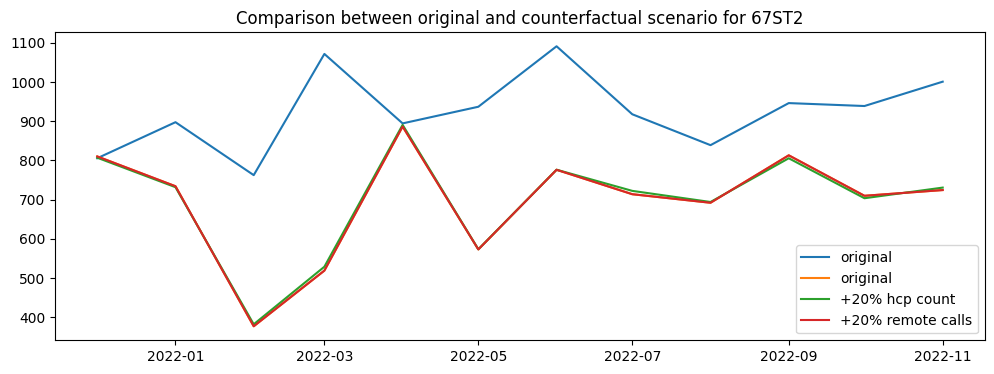

Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 2355, in ray._raylet._auto_reconnect.wrapper
  File "python/ray/_raylet.pyx", line 2502, in ray._raylet.GcsClient.internal_kv_del
  File "python/ray/_raylet.pyx", line 455, in ray._raylet.check_status
ray.exceptions.RpcError: failed to connect to all addresses; last error: UNKNOWN: ipv4:10.123.138.232:55755: Failed to connect to remote host: Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 984, in _find_and_load_unlocked
ModuleNotFoundError: No module named 'grpc'


In [167]:
col =  'AutoLSTM-median' #'AutoTFT-median' #'AutoNHITS-median'

brick_id = '67ST2'

plt.figure(figsize=(12,4))
plt.plot(df_nixtla[df_nixtla.unique_id==brick_id].iloc[-12:].ds, df_nixtla[df_nixtla.unique_id==brick_id].iloc[-12:].y, label='original')
plt.plot(fcst_df[fcst_df.index==brick_id].ds, fcst_df[fcst_df.index==brick_id][col], label='original')
plt.plot(fcst_df2[fcst_df2.index==brick_id].ds, fcst_df2[fcst_df2.index==brick_id][col], label='+20% hcp count')
plt.plot(fcst_df2[fcst_df3.index==brick_id].ds, fcst_df3[fcst_df3.index==brick_id][col], label='+20% remote calls')
plt.legend()
plt.title('Comparison between original and counterfactual scenario for 67ST2')
plt.show()